# Fragility Analysis on MDOF System

## Introduction

This Jupyter Notebook provides a structured workflow for performing a nonlinear time-history analyses (NLTHA), namely cloud analysis on multi-degree-of-freedom (MDOF) structural models using natural unscaled ground-motion records. By combining functions for MDOF calibration, modeling and dynamic analysis, the notebook enables the setup, execution, and post-processing of structural responses under earthquake loading.

The main goals of this notebook:

1. **Calibrate MDOF models based on single-degree-of-freedom (SDOF) oscillator capacity**: Calibrate storey-based force-deformation relationships using SDOF capacity curve definition (spectral displacement-spectral acceleration) based on the methodology of Lu et al. (2020) and other modifications to account for distinct response typologies (i.e., bilinear, trilinear and quadrilinear backbone definitions)

2. **Compile and construct MDOF Models in OpenSees**: Define and assemble MDOF models by specifying essential structural properties, including mass, heights, fundamental period and nonlinear response characteristics at each degree of freedom

3. **Run Nonlinear Time-History Analysis (NLTHA) in OpenSees**: Simulate the dynamic response of MDOF structures under time-dependent inputs, such as ground motion records, to realistically assess structural behavior and response metrics (e.g., peak storey drifts, peak floor accelerations) under loading conditions and extract critical response metrics and model information.

4. **Fragility Analysis**: Postprocess cloud analysis results to fit a probabilistic seismic demand model (PSDM) to ultimately estimate the median seismic intensities and total dispersion associated with arbitrary demand-based thresholds (i.e., maximum interstorey drift-based) and construct the fragility functions relating damage state exceedance probabilities with increasing levels of ground-shaking.

5. **Vulnerability Analysis**: Integrate fragility functions with consequence models (i.e., damage-to-loss models) to determine the continuous relationship between a decision variable and increasing levels of ground-shaking.


The notebook provides a step-by-step guide, covering each phase from MDOF model calibration, setup to input parameter configuration, analysis execution, and detailed results extraction and postprocessing. Users should have some familiarity with python scripts, structural dynamics, computational modeling, and performance-based earthquake engineering to fully benefit from this material.

---

## References

[1] Jalayer F, Ebrahimian H, Miano A, Manfredi G, Sezen H. Analytical fragility assessment using unscaled ground motion records. Earthquake Engng Struct Dyn. 2017; 46: 2639–2663. https://doi.org/10.1002/eqe.2922

[2] Lu X, McKenna F, Cheng Q, Xu Z, Zeng X, Mahin SA. An open-source framework for regional earthquake loss estimation using the city-scale nonlinear time history analysis. Earthquake Spectra. 2020;36(2):806-831. doi:10.1177/8755293019891724

## Initialize Libraries ##

In [1]:
import os
import sys
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import the classes necessary for structural analysis
from openquake.vmtk.postprocessor import postprocessor                  # oq-vtmk postprocessing class
from openquake.vmtk.plotter       import plotter                        # oq-vmtk plotting class
from openquake.vmtk.utilities     import import_from_pkl, export_to_pkl # oq-vmtk utility class

## Import Analysis Data ##

In [5]:
# Define the directory of the ground-motion and cloud analysis dictionaries
input_directory  = './input'            

# Import the intensity measure dictionary 
ims  = import_from_pkl(os.path.join(input_directory, 'imls_esrm20.pkl'))  

# Import the analysis dictionary
ansys_dict = import_from_pkl(os.path.join(input_directory, 'ansys_out.pkl'))  

## Define Cloud Analysis Probabilistic Seismic Demand Model Parameters ##

In [6]:
# Intensity measures to use for postprocessing cloud analyses
IMTs      = ['PGA']

# Damage thresholds (maximum peak storey drift values in rad)
damage_thresholds    =  [0.00150, 0.00545, 0.00952, 0.0135] 

# The lower limit to be applied for censoring edp values (below 0.1 the minimum threshold for slight damage is considered a negligible case)
lower_limit = 0.1*damage_thresholds[0]

# The upper limit to be applied for consoring edp values (above 1.5 the maximum threshold is considered a collapse case) 
censored_limit = 1.5*damage_thresholds[-1]   

In [15]:
# Initialise the postprocessor class
pp = postprocessor()

# Initialise the plotter class
pl = plotter()

# Loop over the intensity measure types and perform cloud regression to fit the probabilistic seismic demand-capacity model
for _, current_imt in enumerate(IMTs):
    
    # Import the current intensity measure type
    imls = ims[f'{current_imt}']                   

    # Import the engineering demand parameters (i.e., mpsd) from the analysis dictionary (processed from example 2)
    edps = ansys_dict['max_peak_drift_list']  
    
    # Process cloud analysis results using the "do_cloud_analysis" function called from "postprocessor" 
    # The output will be automatically stored in a dictionary

    # Fragility Method 1: Lognormal CDF considering no additional modelling uncertainty
    cloud_dict_frag_1 = pp.do_cloud_analysis(imls,
                                             edps,
                                             damage_thresholds,
                                             lower_limit,
                                             censored_limit,
                                             sigma_build2build=0.0,
                                             fragility_method = 'lognormal')


    # Fragility Method 2: Lognormal CDF considering an additional modelling uncertainty of 0.3
    cloud_dict_frag_2 = pp.do_cloud_analysis(imls,
                                             edps,
                                             damage_thresholds,
                                             lower_limit,
                                             censored_limit,
                                             sigma_build2build=0.3,
                                             fragility_method = 'lognormal')

    # Fragility Method 3: Lognormal CDF considering an additional modelling uncertainty of 0.3 and fragility rotation about the 20th percentile
    cloud_dict_frag_3 = pp.do_cloud_analysis(imls,
                                             edps,
                                             damage_thresholds,
                                             lower_limit,
                                             censored_limit,
                                             sigma_build2build=0.3,
                                             fragility_rotation = True,
                                             rotation_percentile = 0.20,
                                             fragility_method = 'lognormal')


    # Fragility Method 4: Generalised Linear Model (GLM) using a logit link function
    cloud_dict_frag_4 = pp.do_cloud_analysis(imls,
                                             edps,
                                             damage_thresholds,
                                             lower_limit,
                                             censored_limit,
                                             fragility_method = 'logit')

    # Fragility Method 5: Generalised Linear Model (GLM) using a probit function
    cloud_dict_frag_5 = pp.do_cloud_analysis(imls,
                                             edps,
                                             damage_thresholds,
                                             lower_limit,
                                             censored_limit,
                                             fragility_method = 'probit')

    # Fragility Method 6: Continuous link model (CLM) or ordinal
    cloud_dict_frag_6 = pp.do_cloud_analysis(imls,
                                             edps,
                                             damage_thresholds,
                                             lower_limit,
                                             censored_limit,
                                             fragility_method = 'ordinal')

[ 0.05   0.056  0.062  0.069  0.077  0.086  0.096  0.107  0.119  0.132
  0.147  0.164  0.183  0.204  0.227  0.253  0.282  0.314  0.35   0.39
  0.435  0.484  0.54   0.601  0.67   0.746  0.832  0.927  1.032  1.15
  1.282  1.428  1.591  1.773  1.975  2.201  2.452  2.732  3.044  3.392
  3.779  4.21   4.691  5.227  5.824  6.489  7.23   8.055  8.975 10.   ]
[[2.30564529e-02 5.99993399e-04 7.93844738e-05 1.94532665e-05]
 [3.41541475e-02 1.07931432e-03 1.55748568e-04 4.03202893e-05]
 [4.75548980e-02 1.78664769e-03 2.78619269e-04 7.57618153e-05]
 [6.58719137e-02 2.96356492e-03 5.01223086e-04 1.43487981e-04]
 [8.99018872e-02 4.85647567e-03 8.92240339e-04 2.69206222e-04]
 [1.20160806e-01 7.78786458e-03 1.55444080e-03 4.94382807e-04]
 [1.56769170e-01 1.21500754e-02 2.63211696e-03 8.81961036e-04]
 [1.99399974e-01 1.83857825e-02 4.31536539e-03 1.52186262e-03]
 [2.47299167e-01 2.69562860e-02 6.83935242e-03 2.53514230e-03]
 [2.99368677e-01 3.83018052e-02 1.04774618e-02 4.07564823e-03]
 [3.58136732e-01

## Explore Fragility Function Models ##

[0.18693341 0.42567219 0.60755743 0.75918307]


(0.0, 1.0)

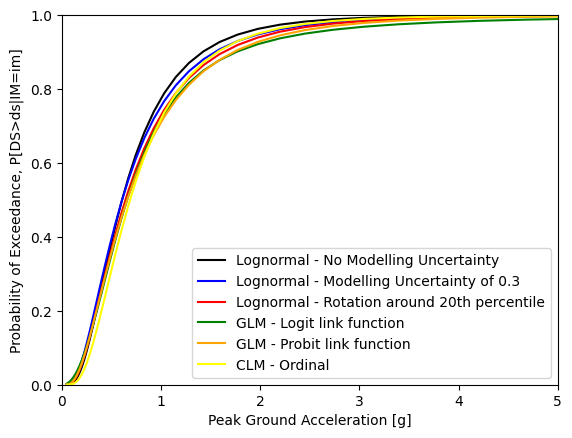

In [29]:
# Fragility function parameters can be easily retrieved from the output of the pp.do_cloud_analysis() method
# by calling the dictionary key 'fragility' (e.g., output['fragility']).
# where all outputs associated with fragility analysis are stored including the median and dispersions associated with each damage state,
# the sampled intensity measure levels and the probabilities of exceedance for each damage state.
# Example:
print(cloud_dict_frag_1['fragility']['medians']) # this will print out the median seismic intensities (in g) required to attain each demand-based damage state

# Visualise the different fragility analysis methods assumptions on the end result (i.e., probabilities of exceedance)

# Fragility function method 1 (Extensive Damage)
plt.plot(cloud_dict_frag_1['fragility']['intensities'], cloud_dict_frag_1['fragility']['poes'][:,2], color = 'black', 
         label = 'Lognormal - No Modelling Uncertainty') 

# Fragility function method 2 (Extensive Damage)
plt.plot(cloud_dict_frag_2['fragility']['intensities'], cloud_dict_frag_2['fragility']['poes'][:,2], color = 'blue', 
         label = 'Lognormal - Modelling Uncertainty of 0.3') 

# Fragility function method 3 (Extensive Damage)
plt.plot(cloud_dict_frag_3['fragility']['intensities'], cloud_dict_frag_3['fragility']['poes'][:,2], color = 'red', 
         label = 'Lognormal - Rotation around 20th percentile') 

# Fragility function method 4 (Extensive Damage)
plt.plot(cloud_dict_frag_4['fragility']['intensities'], cloud_dict_frag_4['fragility']['poes'][:,2], color = 'green', 
         label = 'GLM - Logit link function') 

# Fragility function method 5 (Extensive Damage)
plt.plot(cloud_dict_frag_5['fragility']['intensities'], cloud_dict_frag_5['fragility']['poes'][:,2], color = 'orange', 
         label = 'GLM - Probit link function') 

# Fragility function method 6 (Extensive Damage)
plt.plot(cloud_dict_frag_6['fragility']['intensities'], cloud_dict_frag_6['fragility']['poes'][:,2], color = 'yellow', 
         label = 'CLM - Ordinal') 

plt.legend()
plt.xlabel('Peak Ground Acceleration [g]')
plt.ylabel('Probability of Exceedance, P[DS>ds|IM=im]')
plt.xlim([0,5])
plt.ylim([0,1])
